In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap

In [2]:
f = 1.5e9 #Hz
me = 9.10938356e-31 #kg (electron)
q = -1.60217662e-19 # coulombs

In [3]:
# loading E-field (may takes some time depending on the file size)
data = np.loadtxt("2layer_70V_1p5_GHz_realsmooth_EXEy_250nm_x0to1mm_y0p25to1mm.fld", skiprows = 2)
for i in range(len(data)):
    for j in range(3):
        data[i][j] = round(data[i][j], 10)

In [4]:
# manipulating E field data and read it into a pandas dataframe
df_RF = pd.DataFrame(data, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max, x_min = df_RF.x.max(), df_RF.x.min()
y_max, y_min = df_RF.y.max(), df_RF.y.min()
Nx, Ny = df_RF.x.nunique() - 1, df_RF.y.nunique() - 1 # numbers of intervals that divide each dimension
dx, dy = (x_max-x_min)/Nx, (y_max-y_min)/Ny # interval size

## Calculating the trap center coordinate

In [5]:
df_RF["absE"] = np.sqrt(df_RF.Ex**2 + df_RF.Ey**2)

In [6]:
y_trap_center = df_RF.sort_values(by=['absE']).iloc[0, 1]
print("The y coordinate for the trap center is: ", y_trap_center*1.0e6, "um")

The y coordinate for the trap center is:  508.75 um


In [7]:
df_RF["y"] = df_RF.y - y_trap_center

In [8]:
x_max, x_min = df_RF.x.max(), df_RF.x.min()
y_max, y_min = df_RF.y.max(), df_RF.y.min()
Nx, Ny = df_RF.x.nunique() - 1, df_RF.y.nunique() - 1 # numbers of intervals that divide each dimension
dx, dy = (x_max-x_min)/Nx, (y_max-y_min)/Ny # interval size
print("x_max = ", x_max*1.0e3, "mm")
print("y_max = ", y_max*1.0e3, "mm")
print("x_min = ", x_min*1.0e3, "mm")
print("y_min = ", y_min*1.0e3, "mm")
print("spatial resolution x: ", dx*1.0e6, "um")
print("spatial resolution y: ", dy*1.0e6, "um") 

x_max =  1.0 mm
y_max =  0.49125 mm
x_min =  0.0 mm
y_min =  -0.25875 mm
spatial resolution x:  0.25 um
spatial resolution y:  0.25 um


In [9]:
# instantiating the trap_RF object from quarter_trap class
trap_RF = half_trap(df_RF, x_max, x_min, y_max, y_min, Nx, Ny, dx, dy, f=f, q=q, m=me)

In [10]:
# testing the implementation of get_row_index
n = trap_RF.get_row_index(341.77891e-6, 198.7634e-6)
trap_RF.df.iloc[n, 1]

0.00019875000000000003

## Single particle simulation

x_max =  1000.0 um
y_max =  491.25000000000006 um
x_min =  0.0 um
y_min =  -258.75 um
Spatial resolution x:  0.25 um
Spatial resolution y:  0.25 um
Time step for simulation:  0.01 ns
Program runtime: 0.7 s


Text(0.5,1,'y vs x')

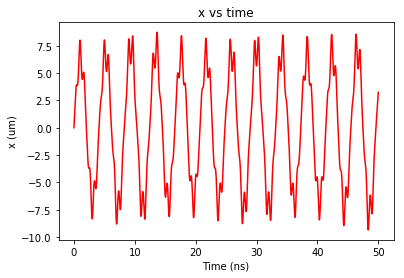

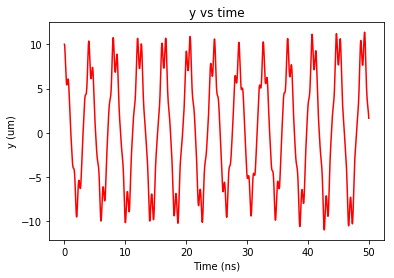

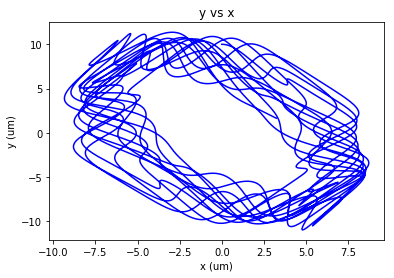

In [11]:
start = time.time()
# simulation configuration
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation
T = 4.0 # kelvin
rho = 10.0e-6 # initial distance from the trap center
phi = np.pi/2 # direction of initial position vector
v = np.sqrt(2*trap_RF.kB*T/trap_RF.m) # typical thermal speed
theta = 0 # direction of initial velocity
# simulate particle trajectory using trap_RF object
result = trap_RF.traj(rho, phi, v, theta, dt, t_max)
t_s = np.array(result[0])
x_traj = np.array(result[1])
y_traj = np.array(result[2])

print("x_max = ", x_max*1.0e6, "um")
print("y_max = ", y_max*1.0e6, "um")
print("x_min = ", x_min*1.0e6, "um")
print("y_min = ", y_min*1.0e6, "um")
print("Spatial resolution x: ", dx*1.0e6, "um")
print("Spatial resolution y: ", dy*1.0e6, "um")
print("Time step for simulation: ", dt*1.0e9, "ns")
end = time.time()
print("Program runtime:", round(end-start, 1), "s")

# Plotting the results
plt.figure()
plt.plot(t_s*1.0e9, x_traj*1.0e6, 'r-')
plt.xlabel("Time (ns)")
plt.ylabel("x (um)")
plt.title("x vs time")

plt.figure()
plt.plot(t_s*1.0e9, y_traj*1.0e6, 'r-')
plt.xlabel("Time (ns)")
plt.ylabel("y (um)")
plt.title("y vs time")

plt.figure()
plt.plot(x_traj*1.0e6, y_traj*1.0e6, 'b-')
plt.xlabel("x (um)")
plt.ylabel("y (um)")
plt.title("y vs x")

Simulating T =  4.0 kelvin
The result for T =  4.0 kelvin:
Simulating T =  20.0 kelvin
The result for T =  20.0 kelvin:
Simulating T =  100.0 kelvin
The result for T =  100.0 kelvin:
Simulating T =  300.0 kelvin
The result for T =  300.0 kelvin:


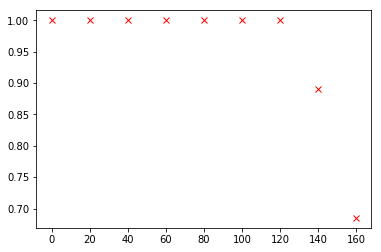

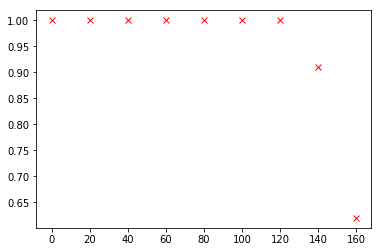

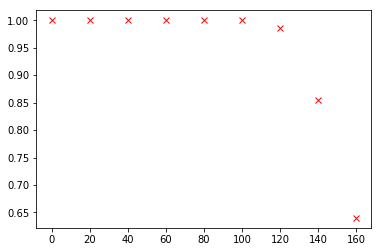

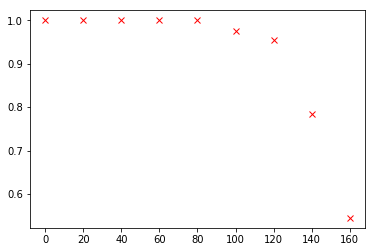

In [15]:
dt = 1.0e-11 #s
t_max = 50.0e-9 # maximum time duration of the simulation

#initial condition
rho_s = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0]
rho_s = np.array(rho_s) * 1.0e-6
N_samples = 200

# A dictionary, taking temperature as key and the value is a 
# list of success rates correspond to each rou in rou_s
success_rate = dict()
errors = dict()
for T in [4.0, 20.0, 100.0, 300.0]:
    v = np.sqrt(2*trap_RF.kB*T/me)
    success_rate[T] = [] 
    errors[T] = []
    print("Simulating T = ", T, "kelvin")
    for rho in rho_s:
        result = []
        phi = np.random.rand(N_samples) * np.pi * 2
        theta = np.random.rand(N_samples) * np.pi * 2
        for i in range(N_samples):
            if trap_RF.trapped(rho, phi[i], v, theta[i], dt, t_max):
                result.append(1)
            else:
                result.append(0)
        success_rate[T].append(np.mean(result))
        errors[T].append(np.std(result)/np.sqrt(N_samples))
    print("The result for T = ", T, "kelvin:")
    plt.figure()
    plt.plot(rho_s*1.0e6, success_rate[T], 'rx')

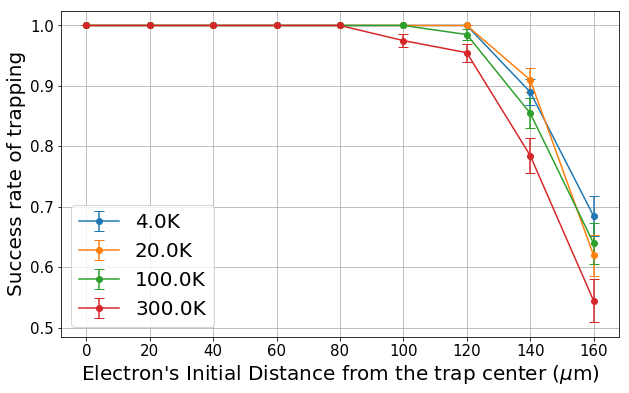

In [16]:
plt.figure(figsize=(10,6))
for T in [4.0, 20.0, 100.0, 300.0]:
    #plt.plot(rou_s*1.0e6, success_rate[T], label = str(T) + "K")
    plt.errorbar(rho_s*1.0e6, success_rate[T], yerr=errors[T], fmt="-o", label = str(T) + "K", capsize=5)
    plt.xlabel("$rho$")
plt.legend(fontsize=20)
plt.xlabel("Electron's Initial Distance from the trap center ($\mu$m)", fontsize=20)
plt.ylabel("Success rate of trapping", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)